# Imports

In [2]:
# Standard library imports
import os
import json
import warnings
import pickle
import ast

# Third-party library imports
import transformers
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from craft_text_detector import Craft # Need to edit the saving function to prepend 0's
from torchvision import datasets

import taxonerd
from taxonerd import TaxoNERD
import spacy

# Local application/library specific imports
import trocr
import detr

# from importlib import reload
# reload(detr)

# Directories

In [315]:
# Suppressing all the huggingface warnings
SUPPRESS = True
if SUPPRESS:
    from transformers.utils import logging
    logging.set_verbosity(40)
# Turning off this warning, isn't relevant for this application
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

# Location of input images
inputdir = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/TROCR_Training/goodfiles/'
# inputdir = 'evaluation-dataset/handwritten-typed-text-classification/data/Doc_Classification/output/handwritten/' # typed/handwritten
# Location of images after label extraction (also input directory to CRAFT)
# workdir = inputdir
workdir = '/projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr/label-extraction/data/label-extraction-intermediate-files/' # update this to the desired directory on scc

# Location of the segmentations
output_dir_craft = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/craft_output_files/'
# Location to save all output files
save_dir = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/saved_results_trocr/'
# For ground truth labels 
workdir2 = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/drago_testdata/gt_labels' # update this to the desired directory on scc

# Corpus files
ALL_SPECIES_FILE = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/corpus_taxon/output/possible_species.pkl'
ALL_GENUS_FILE = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/corpus_taxon/output/possible_genus.pkl'
ALL_TAXON_FILE = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-new/ml-herbarium/corpus/corpus_taxon/corpus_taxon.txt'

In [316]:
! ls /projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr/label-extraction/data/label-extraction-intermediate-files/ | wc -l
! ls /projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/craft_output_files/ | wc -l

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
0
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
0


In [313]:
! rm -rf /projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr/label-extraction/data/label-extraction-intermediate-files/*
! rm -rf /projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/craft_output_files/*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Running DETR to extract labels from images

In [317]:
# Use the DETR for inference (adopted from Freddie (https://github.com/freddiev4/comp-vision-scripts/blob/main/object-detection/detr.py))
detr_model = 'spark-ds549/detr-label-detection'
# The DETR model returns the bounding boxes of the lables indentified from the images
# We will utilize the bounding boxes to rank lables in the downstream task
label_bboxes = detr.run(inputdir, workdir, detr_model)

# Save the label bounding boxes into a pickle file
pickle.dump(label_bboxes, open(save_dir+"label_boxes.pkl", "wb"))

INFO:detr-objection-detection:Getting KabilanM/detr-label-extraction pretrained model...
INFO:detr-objection-detection:Setting up object detection pipeline...
INFO:detr-objection-detection:Running object detection pipeline...
INFO:detr-objection-detection:Getting image at path evaluation-dataset/handwritten-typed-text-classification/data/Doc_Classification/output/handwritten/1320398138.jpg...
INFO:detr-objection-detection:Now have image object <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=7319x10319 at 0x1534F8DE8190>
INFO:root:Masking image...
INFO:root:Saved image to location: /projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr/label-extraction/data/label-extraction-intermediate-files/1320398138.jpg
INFO:detr-objection-detection:Getting image at path evaluation-dataset/handwritten-typed-text-classification/data/Doc_Classification/output/handwritten/2848499425.jpg...
INFO:detr-objection-detection:Now have image object <PIL.JpegImagePlugin.JpegImageFile

In [318]:
# we remove images with no bounding boxes found
label_bboxes = pickle.load(open(save_dir+"label_boxes.pkl", "rb"))
keys_to_remove = []

print(f"Total number of images: {len(label_bboxes)}")

for key, value in label_bboxes.items():
    if(len(value) == 0):
        keys_to_remove.append(key)

for key in keys_to_remove:
    label_bboxes.pop(key)

print(f"Number of images with bounding boxes: {len(label_bboxes)}")

Total number of images: 117
Number of images with bounding boxes: 117


In [319]:
# these are the images with no bounding boxes
keys_to_remove

[]

# Running craft and saving the segmented images

In [320]:
# initialize the CRAFT model
craft = Craft(output_dir = output_dir_craft, 
              export_extra = False, 
              text_threshold = .7, 
              link_threshold = .4, 
              crop_type="poly", 
              low_text = .3, 
              cuda = True)

# CRAFT on images to get bounding boxes
images = []
corrupted_images = []
no_segmentations = []
boxes = {}
count= 0
img_name = []
box = []
file_types = (".jpg", ".jpeg",".png")
    
for filename in tqdm(sorted(label_bboxes.keys())):
    image = workdir+filename
    try:
        img = Image.open(image) 
        img.verify() # Check that the image is valid
        bounding_areas = craft.detect_text(image)
        if len(bounding_areas['boxes']): #check that a segmentation was found
            images.append(image)
            boxes[image] = bounding_areas['boxes']
            
        else:
            no_segmentations.append(image)
    except (IOError, SyntaxError) as e:
        corrupted_images.append(image)

# Save the bounding boxes into a pickle file
pickle.dump(boxes, open(save_dir+"boxes.pkl", "wb"))

100%|██████████| 117/117 [01:41<00:00,  1.15it/s]


# Getting all the segmented images into a dataloader, and loading model and processor for trocr

In [321]:
# Deleting empty folders, which occurs if some of the images get no segementation from CRAFT
root = output_dir_craft
folders = list(os.walk(root))[1:]
deleted = []
for folder in folders:
    if not folder[2]:
        deleted.append(folder)
        os.rmdir(folder[0])
        
# Setting up the TrOCR model and processor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten") # cache_dir
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").to(device)

# Use all available gpus
model_gpu= nn.DataParallel(model,list(range(torch.cuda.device_count()))).to(device)

# Dataloader for working with gpus
trainset = datasets.ImageFolder(output_dir_craft, transform = processor)
testloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=False)

# For matching words to image
filenames = [s.replace('_crops', '') for s in list(trainset.class_to_idx)]

# For matching the image name with the label name
word_log_dic = {k: v for k,v in enumerate(filenames)}
# For matching the image name with the transriptions
words_identified = {k: [] for v,k in enumerate(filenames)}

# Saving the filenames, word_log_dic and words_identified

In [322]:
# Save filenames
with open(save_dir+'filenames.txt', 'w') as fp:
    for item in filenames:
        # write each item on a new line
        fp.write("%s\n" % item)
# Save word_log_dic 
with open(save_dir+'word_log_dic.json', 'w') as fp:
    json.dump(word_log_dic, fp)
# Save words_identified
with open(save_dir+'words_identified.json', 'w') as fp:
    json.dump(words_identified, fp)

# Running TrOCR on the Segmented Images from Craft

In [323]:
#Storing the outputs
results,confidence,labels = trocr.evaluate_craft_seg(model,processor, words_identified,word_log_dic,testloader,device)
#Saving all the outputs in dataframe
df = pd.DataFrame(list(zip(results,confidence,labels)),columns = ['Results','Confidence','Labels'])
df.to_pickle(save_dir+'full_results.pkl')
display(df.head())

Transcribing Image Segments: 100%|██████████| 81/81 [01:17<00:00,  1.05it/s]


,Results,Confidence,Labels
0,plants of California,0.000466,0
1,"Calaveras. Ranger Station, Stanislaus Forest,",0.483036,0
2,"Avery, Calaveras County.",0.299946,0
3,01237442,0.120719,0
4,no. 9132,0.391138,0


In [324]:
# First part of final csv with results, confidence level from tr-ocr, and label
df = pd.read_pickle(save_dir+'full_results.pkl')
boxes = pickle.load(open(save_dir+"boxes.pkl", "rb"))
combined_df = trocr.combine_by_label(df)

# Adding the image path and all bounding boxes 
df_dictionary = pd.DataFrame(boxes.items(), columns=['Image_Path', 'Bounding_Boxes'])
combined_df = pd.concat([combined_df, df_dictionary], axis=1, join='inner')
display(combined_df.head())

,Labels,Transcription,Transcription_Confidence,Image_Path,Bounding_Boxes
0,0,"[plants of California, Calaveras. Ranger Stati...","[0.0004661529092118144, 0.4830363392829895, 0....",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4427.475, 7904.178], [5505.9624, 7904.178],..."
1,1,"[Flora Hawaiiansis, Collected by C. N. Forbes ...","[0.040508534759283066, 0.0575096495449543, 9.6...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4610.7188, 7824.25], [5379.172, 7824.25], [..."
2,2,"[U.S. NATIONAL HERBARIUM, Revised for the Mono...","[0.2526762783527374, 0.9949204325675964, 0.584...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4235.6646, 327.2233], [5288.775, 311.50528]..."
3,3,"[Plantae austroamericanae., 2d.e.cynthia, subm...","[0.3785373270511627, 1.5443114534718916e-05, 4...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4524.668, 7593.46], [5625.5522, 7613.8457],..."
4,4,"[plants of the Dominican Republic, 3 3 6 ( Cor...","[0.049272287636995316, 0.14903457462787628, 0....",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4308.3843, 7912.784], [5772.672, 7912.784],..."


In [325]:
#Save intermediate file
combined_df.to_pickle(save_dir+'test.pkl')

In [326]:
combined_df.to_csv("./combined_df.csv")

# Reading in the ground truth files for tested images

In [327]:
# Reading in the ground truth values

gt_t = workdir2+'/taxon_gt.txt'
Taxon_truth = { line.split(":")[0] : line.split(": ")[1].strip() for line in open(gt_t, "r", encoding="utf-8")}

gt_g = workdir2+'/geography_gt.txt'
Geography_truth = { line.split(":")[0] : line.split(": ")[1].strip() for line in open(gt_g, "r", encoding="utf-8") }

gt_c = workdir2+'/collector_gt.txt'
Collector_truth = { line.split(":")[0] : line.split(": ")[1].strip() for line in open(gt_c, "r", encoding="utf-8") }

comparison_file = {"Taxon":Taxon_truth,"Countries":Geography_truth,"Collector":Collector_truth}

In [328]:
Taxon_truth_sample = {k: Taxon_truth[k] for k in list(Taxon_truth)[:10]}

# view subset of the taxon truth
print(Taxon_truth_sample)

{'1697659851': 'Euphrasia officinalis', '2573258025': 'Bryoerythrophyllum recurvirostrum', '2597666444': 'Carduus tenuiflorus', '1931288980': 'Agoseris parviflora', '1930241969': 'Spiraea canescens', '1929944910': 'Chylismia scapoidea', '1931007576': 'Carex typhina', '1928514234': 'Stachys hispida', '1928658806': 'Solanum donianum', '1931124118': 'Suaeda nigra'}


# Use TaxoNERD to recognize taxons from detected text

In [329]:
ner = TaxoNERD(prefer_gpu=False) # set to "true" if GPU is accessible

In [330]:
# ! python -m spacy download en_core_web_md
# ! python -m spacy download en_core_web_sm
# ! python -m spacy download en_core_web_trf

# from numpy.linalg import norm

# # Load the spaCy model for date and location recognition
# w2v = spacy.load("en_core_web_md")

# # Convert word to its vector representation
# def word2vec(word):
#     return w2v(word).vector

# # Compute cosine similarity between two word vectors
# def cosdis(v1, v2):
#     v1_norm = norm(v1)
#     v2_norm = norm(v2)
#     if v1_norm > 0 and v2_norm > 0:
#         return np.dot(v1, v2) / (v1_norm * v2_norm)
#     else:
#         return 0.0

In [331]:
# utility functions for finding cosine similarity

def word2vec(word):
    from collections import Counter
    from math import sqrt

    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))

    # return a tuple
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]

In [332]:
# Modify cache folder for taxonnerd (I changed the module codebase)
os.environ['TAXONERD_CACHE']='/projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr'
os.getenv("TAXONERD_CACHE")

'/projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr'

In [333]:
# ! pip install https://github.com/nleguillarme/taxonerd/releases/download/v1.5.0/en_core_eco_md-1.0.2.tar.gz

nlp = ner.load(
    model="en_core_eco_md", # en_core_eco_md
    linker="gbif_backbone",
    threshold=0 # we set the threshold to "0" so that we can collate results at various thresholds later
)

INFO:nmslib:Loading index from /projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr/datasets/bdb932a2c23507c7fb54dd2eff1ca3ac71005d9913e22542bb87ff92405076e5.nmslib_index.bin
INFO:nmslib:Loading regular index.
INFO:nmslib:Finished loading index
INFO:nmslib:Set HNSW query-time parameters:
INFO:nmslib:ef(Search)         =20
INFO:nmslib:algoType           =2
INFO:nmslib:Set HNSW query-time parameters:
INFO:nmslib:ef(Search)         =200
INFO:nmslib:algoType           =2


In [334]:
# use a transformer model from spaCy for person and location information
nlp_loc = spacy.load("en_core_web_trf")

In [335]:
# read dataframe from CSV file saved previously
combined_df = pickle.load(open(save_dir+'test.pkl', "rb"))
combined_df.shape[0]

117

In [336]:
# verify that the dataframe has been read correctly
combined_df.head()

,Labels,Transcription,Transcription_Confidence,Image_Path,Bounding_Boxes
0,0,"[plants of California, Calaveras. Ranger Stati...","[0.0004661529092118144, 0.4830363392829895, 0....",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4427.475, 7904.178], [5505.9624, 7904.178],..."
1,1,"[Flora Hawaiiansis, Collected by C. N. Forbes ...","[0.040508534759283066, 0.0575096495449543, 9.6...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4610.7188, 7824.25], [5379.172, 7824.25], [..."
2,2,"[U.S. NATIONAL HERBARIUM, Revised for the Mono...","[0.2526762783527374, 0.9949204325675964, 0.584...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4235.6646, 327.2233], [5288.775, 311.50528]..."
3,3,"[Plantae austroamericanae., 2d.e.cynthia, subm...","[0.3785373270511627, 1.5443114534718916e-05, 4...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4524.668, 7593.46], [5625.5522, 7613.8457],..."
4,4,"[plants of the Dominican Republic, 3 3 6 ( Cor...","[0.049272287636995316, 0.14903457462787628, 0....",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4308.3843, 7912.784], [5772.672, 7912.784],..."


In [337]:
# use TaxoNERD for entity recognition and linking against the GBIF database

taxon_output = []
confidence_output = []

# predict taxons for text detected from each image
for index, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    try:
        # Convert the strings in the 'list_column' to actual lists
        temp = ast.literal_eval(row["Transcription"])
    except ValueError:
        temp = row["Transcription"]

    # construct a single string out of all the detected text
    input_text = " ".join(temp)
    doc = ner.find_in_text(input_text)
    entities = []

    if(input_text == ""):
        taxon_output.append("")
        confidence_output.append(float(0))
        continue
        
    try:
        # append linked taxon entity with the highest confidence
        for entity in doc.entity:
            entities.append(entity[0])

        result = max(entities, key=lambda x: x[2])        
        taxon_output.append(str(result[1]))
        confidence_output.append(float(result[2]))

    except AttributeError:
        # append empty strings when no entity is detected
        taxon_output.append("")
        confidence_output.append(float(0))

100%|██████████| 117/117 [02:34<00:00,  1.32s/it]


In [338]:
# use spaCy model to recognize date and location from the text

location_output = []
date_output = []

# get date and location for text detected from each image
for index, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    try:
        # Convert the strings in the 'list_column' to actual lists
        temp = ast.literal_eval(row["Transcription"])
    except ValueError:
        temp = row["Transcription"]

    # construct a single string out of all the detected text
    input_text = " ".join(temp)
    doc_loc = nlp_loc(input_text)
    entities = []
    loc_entities = []
    date_entities = []

    if(input_text == ""):
        location_output.append("")
        date_output.append("")
        continue

# append location and date entities recognized in the text
    for ent in doc_loc.ents:
        if(ent.label_ == "LOC"): 
            loc_entities.append(ent.text)
        if(ent.label_ == "DATE"):
            date_entities.append(ent.text)
    # print(loc_entities, date_entities)

# Need to group the locations and dates found based on the label they were found in

100%|██████████| 117/117 [00:16<00:00,  7.25it/s]


In [339]:
# append predicted taxon and confidence scores to the dataframe
combined_df["Taxon_Output"] = taxon_output
combined_df["Confidence_Output"] = confidence_output

In [340]:
combined_df.head()

,Labels,Transcription,Transcription_Confidence,Image_Path,Bounding_Boxes,Taxon_Output,Confidence_Output
0,0,"[plants of California, Calaveras. Ranger Stati...","[0.0004661529092118144, 0.4830363392829895, 0....",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4427.475, 7904.178], [5505.9624, 7904.178],...",,0.00000
1,1,"[Flora Hawaiiansis, Collected by C. N. Forbes ...","[0.040508534759283066, 0.0575096495449543, 9.6...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4610.7188, 7824.25], [5379.172, 7824.25], [...",Clermontia persicifolia,1.00000
2,2,"[U.S. NATIONAL HERBARIUM, Revised for the Mono...","[0.2526762783527374, 0.9949204325675964, 0.584...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4235.6646, 327.2233], [5288.775, 311.50528]...",Hohenbergia antillana Mez,1.00000
3,3,"[Plantae austroamericanae., 2d.e.cynthia, subm...","[0.3785373270511627, 1.5443114534718916e-05, 4...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4524.668, 7593.46], [5625.5522, 7613.8457],...",Cyathea caracasana var. caracasana,0.94514
4,4,"[plants of the Dominican Republic, 3 3 6 ( Cor...","[0.049272287636995316, 0.14903457462787628, 0....",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4308.3843, 7912.784], [5772.672, 7912.784],...",,0.00000


In [341]:
# array to store computed similarity scores
cosine_sim = []
taxon_truth = []

for index, row in combined_df.iterrows():

    # extract image name from the dataframe
    img_name = row["Image_Path"].split("/")[-1][:-4]
    taxon_predicted = row["Taxon_Output"]
    taxon_gt = Taxon_truth[img_name]
    taxon_truth.append(taxon_gt)

    # print(f"Image: {img_name}, Predicted: {taxon_predicted}, Truth: {taxon_gt}")

    # compute cosine similarity between the predicted taxon and ground truth
    try:
        sim = cosdis(word2vec(taxon_gt), word2vec(taxon_predicted))
        cosine_sim.append(sim)
        # print(taxon_gt, taxon_predicted, sim)

    except ZeroDivisionError:
        cosine_sim.append(0)
        # print(taxon_gt, taxon_predicted,"0")

# append similarity scores to the dataframe
combined_df["Taxon_Truth"] = taxon_truth
combined_df["Cosine_Similarity"] = cosine_sim
combined_df.to_pickle(save_dir+"full_results_with_cossim.pkl")

In [342]:
combined_df = pickle.load(open(save_dir+"full_results_with_cossim.pkl", "rb"))

columns_list = combined_df.columns.tolist()
columns_list.remove("Taxon_Truth")
columns_list.insert(-2, "Taxon_Truth")
combined_df[columns_list].head()

,Labels,Transcription,Transcription_Confidence,Image_Path,Bounding_Boxes,Taxon_Output,Taxon_Truth,Confidence_Output,Cosine_Similarity
0,0,"[plants of California, Calaveras. Ranger Stati...","[0.0004661529092118144, 0.4830363392829895, 0....",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4427.475, 7904.178], [5505.9624, 7904.178],...",,Sidalcea asprella,0.00000,0.000000
1,1,"[Flora Hawaiiansis, Collected by C. N. Forbes ...","[0.040508534759283066, 0.0575096495449543, 9.6...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4610.7188, 7824.25], [5379.172, 7824.25], [...",Clermontia persicifolia,Clermontia persicifolia,1.00000,1.000000
2,2,"[U.S. NATIONAL HERBARIUM, Revised for the Mono...","[0.2526762783527374, 0.9949204325675964, 0.584...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4235.6646, 327.2233], [5288.775, 311.50528]...",Hohenbergia antillana Mez,Hohenbergia antillana,1.00000,0.964836
3,3,"[Plantae austroamericanae., 2d.e.cynthia, subm...","[0.3785373270511627, 1.5443114534718916e-05, 4...",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4524.668, 7593.46], [5625.5522, 7613.8457],...",Cyathea caracasana var. caracasana,Cyathea squamipes,0.94514,0.677787
4,4,"[plants of the Dominican Republic, 3 3 6 ( Cor...","[0.049272287636995316, 0.14903457462787628, 0....",/projectnb/sparkgrp/ml-herbarium-grp/summer202...,"[[[4308.3843, 7912.784], [5772.672, 7912.784],...",,Cordia sulcata,0.00000,0.000000


In [351]:
combined_df = pickle.load(open(save_dir+"full_results_with_cossim.pkl", "rb"))
final_taxon_prediction = pd.DataFrame(columns=["Confidence_Threshold", "Num_Taxons_Correct", 
                                               "Num_Taxons_Predicted", "Taxons_Accuracy_Predicted"])
temp_df = pd.DataFrame()

# generate list of similarity thresholds
# sim_threshold = [0.9]
sim_threshold = 0.8

# generate list of confidence thresholds
confidence_threshold = np.arange(0, 1.001, 0.1)

# compute prediction accuracy at each confidence threshold
for conf_threshold in confidence_threshold:
    
    temp_df = combined_df[(combined_df["Confidence_Output"] >= conf_threshold)]
    # print(len(temp_df))
    
    acc_count = (temp_df["Cosine_Similarity"] >= sim_threshold).sum()

    acc_value = acc_count/len(temp_df)

    temp = [conf_threshold, acc_count, len(temp_df), acc_value]
    final_taxon_prediction.loc[len(final_taxon_prediction)] = temp

display(final_taxon_prediction)

,Confidence_Threshold,Num_Taxons_Correct,Num_Taxons_Predicted,Taxons_Accuracy_Predicted
0,0.0,46.0,117.0,0.393162
1,0.1,46.0,83.0,0.554217
2,0.2,46.0,83.0,0.554217
3,0.3,46.0,83.0,0.554217
4,0.4,46.0,83.0,0.554217
5,0.5,46.0,78.0,0.589744
6,0.6,45.0,72.0,0.625000
7,0.7,37.0,58.0,0.637931
8,0.8,28.0,42.0,0.666667
9,0.9,15.0,22.0,0.681818


1. We first obtain the taxon predictions with a confidence score for each taxon.
2. We then compute cosine similarities of the predicted taxons with the ground truth taxons.
3. We then, at each interval of the confidence threashold, compute number of taxons that have a high cosine similarity with the ground truth. The scores above are computed for a specific cosine similarity score ">0.8". We need to perform this step because, the taxons are matched against entries from the `gbif_backbone` database (as part of TaxoNERD) and, the predicted taxon might not exactly match the ground truth and we are accounting for this using cosine similarity.

We can try to use the GBIF database to predict taxons and also experiment with different thresholds for the cosine similarity scores. But, in general, the chosen cosine similarity threshold offers an incremental performance upgrade compared to the last semester's work.

## Before and After DETR Integration Comparison

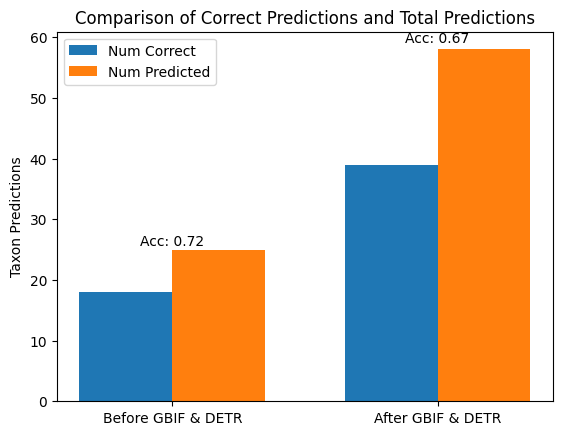

In [346]:
gbif_before_after_comparison = pd.DataFrame([[18, 25, 18/25], [39, 58, 39/58]], columns=["num_correct", "num_predicted", "accuracy"])
gbif_before_after_comparison

import matplotlib.pyplot as plt

# Setting up the figure and axis
fig, ax = plt.subplots()

# Setting the positions and width for the bars
ind = np.arange(len(gbif_before_after_comparison.columns[:-1]))
width = 0.35

# Plotting the 'num_correct' values
bar1 = ax.bar(ind - width/2, gbif_before_after_comparison['num_correct'], width, label='Num Correct')

# Plotting the 'num_predicted' values
bar2 = ax.bar(ind + width/2, gbif_before_after_comparison['num_predicted'], width, label='Num Predicted')

# Annotating the bars with the 'accuracy' values
for i in ind:
    height1 = gbif_before_after_comparison['num_correct'][i]
    height2 = gbif_before_after_comparison['num_predicted'][i]
    max_height = max(height1, height2)
    ax.text(i, 1.01 * max_height,
            f'Acc: {gbif_before_after_comparison["accuracy"][i]:.2f}',
            ha='center', va='bottom')

# Adding some text for labels, title, and legend
ax.set_ylabel('Taxon Predictions')
ax.set_title('Comparison of Correct Predictions and Total Predictions')
ax.set_xticks(ind)
ax.set_xticklabels(['Before GBIF & DETR', 'After GBIF & DETR'])
ax.legend()

# Showing the plot
plt.show()

## Handwritten vs Typed Text Comparison

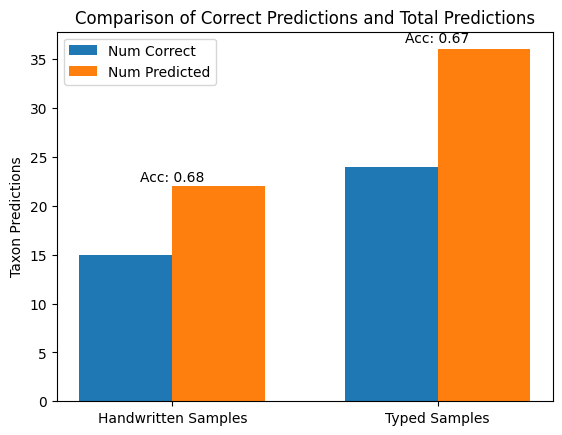

In [353]:
hw_typed_comparison = pd.DataFrame([[15, 22, 15/22], [24, 36, 24/36]], columns=["num_correct", "num_predicted", "accuracy"])

# Setting up the figure and axis
fig, ax = plt.subplots()

# Setting the positions and width for the bars
ind = np.arange(len(hw_typed_comparison.columns[:-1]))
width = 0.35

# Plotting the 'num_correct' values
bar1 = ax.bar(ind - width/2, hw_typed_comparison['num_correct'], width, label='Num Correct')

# Plotting the 'num_predicted' values
bar2 = ax.bar(ind + width/2, hw_typed_comparison['num_predicted'], width, label='Num Predicted')

# Annotating the bars with the 'accuracy' values
for i in ind:
    height1 = hw_typed_comparison['num_correct'][i]
    height2 = hw_typed_comparison['num_predicted'][i]
    max_height = max(height1, height2)
    ax.text(i, 1.01 * max_height,
            f'Acc: {hw_typed_comparison["accuracy"][i]:.2f}',
            ha='center', va='bottom')

# Adding some text for labels, title, and legend
ax.set_ylabel('Taxon Predictions')
ax.set_title('Comparison of Correct Predictions and Total Predictions')
ax.set_xticks(ind)
ax.set_xticklabels(['Handwritten Samples', 'Typed Samples'])
ax.legend()

# Showing the plot
plt.show()